__Skip Connection / Bottleneck Skip connection__

![image](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile7.uf.tistory.com%2Fimage%2F99F0453F5C47F1741338F0)

- ResNet50 부터는 연산량의 줄이기 위해 Residual Block 내에, 1x1, 3x3, 1x1 컨볼루션 연산을 쌓았다. Inception에서 배웠던 것과 같은 개념이다. 1x1 컨볼루션 연산으로 피쳐맵의 갯수를 줄였다가 3x3을 거친 후, 1x1 컨볼루션 연산으로 차원을 늘려준다. 이 과정이 병목 같다 하여 병목레이어(bottleneck layer)라고 부른다.

__Residual Block / Identity Block__

![image](https://datascienceschool.net/upfiles/2e104ff279804e839cef46fc58ef16e7.png)

-  이미지가 반으로 작아진 경우, Identity Block이 사용되며, 입력값을 바로 더하지 않고, 1x1 컨볼루션 연산을 스트라이드 2로 설정하여 피쳐맵의 크기와 갯수를 맞추어준 다음 더해준다. 이를 프로젝션 숏컷(projection shortcut)

__ResNet Structrue by layer__

![image](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99167C335C47F0E315)

In [1]:
# GPU setting
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# modules setting

import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime
from utils import one_hot, train_valid_split, random_minibatch, shuffle
from utils import training_history

# Load Data

In [2]:
train_dir =  '/mnt/disk1/yunseob/courses/19-2_computer vision/data/HHT/6ch/train'
npy_files = os.listdir(train_dir)
npy_files

['normal.npy',
 'ball_7.npy',
 'ball_14.npy',
 'ball_21.npy',
 'inner_7.npy',
 'inner_14.npy',
 'inner_21.npy',
 'outer_7.npy',
 'outer_14.npy',
 'outer_21.npy']

In [3]:
normal = np.load(os.path.join(train_dir, str([i for i in npy_files if 'normal' in i][0])))
ball_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_7' in i][0])))
ball_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_14' in i][0])))
ball_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'ball_21' in i][0])))
inner_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_7' in i][0])))
inner_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_14' in i][0])))
inner_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'inner_21' in i][0])))
outer_7 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_7' in i][0])))
outer_14 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_14' in i][0])))
outer_21 = np.load(os.path.join(train_dir, str([i for i in npy_files if 'outer_21' in i][0])))

normal_y = one_hot(normal, 0, nb_classes = 10)
ball_7_y = one_hot(ball_7, 1, nb_classes = 10)
ball_14_y = one_hot(ball_14, 2, nb_classes = 10)
ball_21_y = one_hot(ball_21, 3, nb_classes = 10)
inner_7_y = one_hot(inner_7, 4, nb_classes = 10)
inner_14_y = one_hot(inner_14, 5, nb_classes = 10)
inner_21_y = one_hot(inner_21, 6, nb_classes = 10)
outer_7_y = one_hot(outer_7, 7, nb_classes = 10)
outer_14_y = one_hot(outer_14, 8, nb_classes = 10)
outer_21_y = one_hot(outer_21, 9, nb_classes = 10)

print("normal:", normal.shape, normal_y.shape)
print("ball_7:", ball_7.shape, ball_7_y.shape)
print("ball_14:", ball_14.shape, ball_14_y.shape)
print("ball_21:", ball_21.shape, ball_21_y.shape)
print("inner_7:", inner_7.shape, inner_7_y.shape)
print("inner_14:", inner_14.shape, inner_14_y.shape)
print("inner_21:", inner_21.shape, inner_21_y.shape)
print("outer_7:", outer_7.shape, outer_7_y.shape)
print("outer_14:", outer_14.shape, outer_14_y.shape)
print("outer_21:", outer_21.shape, outer_21_y.shape)

normal: (750, 100, 100, 6) (750, 10)
ball_7: (750, 100, 100, 6) (750, 10)
ball_14: (750, 100, 100, 6) (750, 10)
ball_21: (750, 100, 100, 6) (750, 10)
inner_7: (750, 100, 100, 6) (750, 10)
inner_14: (750, 100, 100, 6) (750, 10)
inner_21: (750, 100, 100, 6) (750, 10)
outer_7: (750, 100, 100, 6) (750, 10)
outer_14: (750, 100, 100, 6) (750, 10)
outer_21: (750, 100, 100, 6) (750, 10)


# Data split

In [4]:
normal_train_x, normal_train_y, normal_valid_x, normal_valid_y = train_valid_split(normal, normal_y)
print("normal:", normal_train_x.shape, normal_train_y.shape, normal_valid_x.shape, normal_valid_y.shape)

ball_7_train_x, ball_7_train_y, ball_7_valid_x, ball_7_valid_y = train_valid_split(ball_7, ball_7_y)
ball_14_train_x, ball_14_train_y, ball_14_valid_x, ball_14_valid_y = train_valid_split(ball_14, ball_14_y)
ball_21_train_x, ball_21_train_y, ball_21_valid_x, ball_21_valid_y = train_valid_split(ball_21, ball_21_y)
print("ball_7:", ball_7_train_x.shape, ball_7_train_y.shape, ball_7_valid_x.shape, ball_7_valid_y.shape)
print("ball_14:", ball_14_train_x.shape, ball_14_train_y.shape, ball_14_valid_x.shape, ball_14_valid_y.shape)
print("ball_21:", ball_21_train_x.shape, ball_21_train_y.shape, ball_21_valid_x.shape, ball_21_valid_y.shape)

inner_7_train_x, inner_7_train_y, inner_7_valid_x, inner_7_valid_y = train_valid_split(inner_7, inner_7_y)
inner_14_train_x, inner_14_train_y, inner_14_valid_x, inner_14_valid_y = train_valid_split(inner_14, inner_14_y)
inner_21_train_x, inner_21_train_y, inner_21_valid_x, inner_21_valid_y = train_valid_split(inner_21, inner_21_y)
print("inner_7:", inner_7_train_x.shape, inner_7_train_y.shape, inner_7_valid_x.shape, inner_7_valid_y.shape)
print("inner_14:", inner_14_train_x.shape, inner_14_train_y.shape, inner_14_valid_x.shape, inner_14_valid_y.shape)
print("inner_21:", inner_21_train_x.shape, inner_21_train_y.shape, inner_21_valid_x.shape, inner_21_valid_y.shape)

outer_7_train_x, outer_7_train_y, outer_7_valid_x, outer_7_valid_y = train_valid_split(outer_7, outer_7_y)
outer_14_train_x, outer_14_train_y, outer_14_valid_x, outer_14_valid_y = train_valid_split(outer_14, outer_14_y)
outer_21_train_x, outer_21_train_y, outer_21_valid_x, outer_21_valid_y = train_valid_split(outer_21, outer_21_y)
print("outer_7:", outer_7_train_x.shape, outer_7_train_y.shape, outer_7_valid_x.shape, outer_7_valid_y.shape)
print("outer_14:", outer_14_train_x.shape, outer_14_train_y.shape, outer_14_valid_x.shape, outer_14_valid_y.shape)
print("outer_21:", outer_21_train_x.shape, outer_21_train_y.shape, outer_21_valid_x.shape, outer_21_valid_y.shape)

normal: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
ball_7: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
ball_14: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
ball_21: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
inner_7: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
inner_14: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
inner_21: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
outer_7: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
outer_14: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)
outer_21: (638, 100, 100, 6) (638, 10) (112, 100, 100, 6) (112, 10)


In [5]:
train_X = np.vstack([normal_train_x, ball_7_train_x, ball_14_train_x, ball_21_train_x, 
                     inner_7_train_x, inner_14_train_x, inner_21_train_x,
                     outer_7_train_x, outer_14_train_x, outer_21_train_x, ])
train_Y = np.vstack([normal_train_y, ball_7_train_y, ball_14_train_y, ball_21_train_y, 
                     inner_7_train_y, inner_14_train_y, inner_21_train_y,
                     outer_7_train_y, outer_14_train_y, outer_21_train_y, ])
valid_X = np.vstack([normal_valid_x, ball_7_valid_x, ball_14_valid_x, ball_21_valid_x, 
                     inner_7_valid_x, inner_14_valid_x, inner_21_valid_x,
                     outer_7_valid_x, outer_14_valid_x, outer_21_valid_x, ])
valid_Y = np.vstack([normal_valid_y, ball_7_valid_y, ball_14_valid_y, ball_21_valid_y, 
                     inner_7_valid_y, inner_14_valid_y, inner_21_valid_y,
                     outer_7_valid_y, outer_14_valid_y, outer_21_valid_y, ])

print("Training set:", train_X.shape, train_Y.shape)
print("Validation set:", valid_X.shape, valid_Y.shape)

Training set: (6380, 100, 100, 6) (6380, 10)
Validation set: (1120, 100, 100, 6) (1120, 10)


# Model

In [6]:
input_h = 100
input_w = 100
input_ch = 6

ch = 16
# 50 50 16

r_ch_1 = 32
# 25 25 32

r_ch_2 = 32
# 12 12 16

r_ch_3 = 64
# 12 12 32

r_ch_4 = 128
# 6 6 128

n_output = 10

In [7]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
batch_prob = tf.placeholder(tf.bool, name = 'bn_prob')

class ResNet50:
    def __init__(self, ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4):
        self.ch = ch
        self.r_ch_1 = r_ch_1
        self.r_ch_2 = r_ch_2
        self.r_ch_3 = r_ch_3
        self.r_ch_4 = r_ch_4
    def conv(self, x, channel, kernel_size = [3, 3], strides = (1, 1), activation = True):
        conv = tf.layers.conv2d(inputs = x, filters = channel, kernel_size = kernel_size, 
                                strides = strides, padding = "SAME")
        conv = tf.layers.batch_normalization(conv, center=True, scale=True, training=batch_prob)
        if activation == True:
            conv = tf.nn.relu(conv)
        return conv
    
    def maxp(self, conv):
        maxp = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2)
        return maxp

    def res_block(self, x, channel):
        x_shortcut = x
        conv_a = self.conv(x, channel/4, kernel_size = [1, 1])
        conv_b = self.conv(conv_a, channel/4, kernel_size = [3, 3])
        conv_c = self.conv(conv_b, channel, kernel_size = [1, 1])
        return tf.nn.relu(conv_c + x_shortcut)
    
    def id_block(self, x, channel, strides = (2, 2)):
        x_shortcut = x
        conv_2a = self.conv(x, channel/4, kernel_size = [1, 1], strides = strides)
        conv_2b = self.conv(conv_2a, channel/4, kernel_size = [3, 3])
        conv_2c = self.conv(conv_2b, channel, kernel_size = [1, 1], activation = False)
        conv_1 = self.conv(x, channel, kernel_size = [1, 1], strides = strides, activation = False)
        return tf.nn.relu(conv_1 + conv_2c)

    def fc_layer(self, gap, n_output = None):
        flatten = tf.layers.flatten(gap)
        output = tf.layers.dense(inputs = flatten, units = n_output)
        return output

    def global_avg_pooling(self, x):
        gap = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        return gap

    def res_block_rep(self, x, target_ch, n_rep):
        for _ in range(n_rep):
            x = self.res_block(x, target_ch)
        return x

    def inf(self, x):
        """
        conv_1: 1
        id_~ + resnet_~: 16 x 3 = 48
        fc_lay: 1

        total: 50
        """
        conv_1 = self.conv(x, self.ch, strides = (2, 2))
        maxp_1 = self.maxp(conv_1)
        id_1 = self.id_block(maxp_1, self.r_ch_1, strides = (1, 1))
        res_1 = self.res_block_rep(id_1, self.r_ch_1, n_rep = 2)
        id_2 = self.id_block(res_1,self.r_ch_2, strides = (2, 2))
        res_2 = self.res_block_rep(id_2, self.r_ch_2, n_rep = 3)
        id_3 = self.id_block(res_2, self.r_ch_3, strides = (2, 2))
        res_3 = self.res_block_rep(id_3, self.r_ch_3, n_rep = 5)
        id_4 = self.id_block(res_3, self.r_ch_4, strides = (2, 2))
        res_4 = self.res_block_rep(id_4, self.r_ch_4, n_rep = 2)
        gap = self.global_avg_pooling(res_4)
        score = self.fc_layer(gap, n_output)
        return score

    
model = ResNet50(ch, r_ch_1, r_ch_2, r_ch_3, r_ch_4)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

W1215 15:43:09.951502 139638348994304 deprecation.py:323] From <ipython-input-7-f95364146dc4>:16: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1215 15:43:09.957551 139638348994304 deprecation.py:506] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1215 15:43:10.141347 139638348994304 deprecation.py:323] From <ipython-input-7-f95364146dc4>:17: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dep

# Training

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 12.50 %    || 28.12 %    || 2.43493414 || 2.26616669
--------------------------------------------------------------
[*200] || 0.00 %    || 9.38 %    || 2.30083895 || 2.25165224
--------------------------------------------------------------


W1215 15:44:27.970356 139638348994304 deprecation.py:323] From /home/yunseob/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*300] || 0.00 %    || 26.56 %    || 2.32504916 || 2.02751637
--------------------------------------------------------------
[*400] || 37.50 %    || 50.00 %    || 1.69166839 || 1.42925763
--------------------------------------------------------------
[*500] || 62.50 %    || 65.62 %    || 1.33131528 || 1.19850230
--------------------------------------------------------------
[*600] || 62.50 %    || 60.94 %    || 0.90797365 || 0.99025267
--------------------------------------------------------------
[*700] || 87.50 %    || 71.88 %    || 0.48527935 || 0.79196370
--------------------------------------------------------------
[*800] || 87.50 %    || 75.00 %    || 0.35892490 || 0.71634048
--------------------------------------------------------------
[*900] || 62.50 %    || 95.31 %    || 0.75515264 || 0.40288591
--------------------------------------------------------------
[1000] || 87.50 %    || 90.62 %    || 0.32988492 || 0.45365027
--------------------------------------------------------

[6800] || 100.00 %    || 100.00 %    || 0.00034688 || 0.01008336
--------------------------------------------------------------
[6900] || 100.00 %    || 100.00 %    || 0.00639006 || 0.00442539
--------------------------------------------------------------
[7000] || 100.00 %    || 100.00 %    || 0.00629722 || 0.00164420
--------------------------------------------------------------
[7100] || 100.00 %    || 100.00 %    || 0.00205599 || 0.00739977
--------------------------------------------------------------
[7200] || 100.00 %    || 100.00 %    || 0.00108503 || 0.00077560
--------------------------------------------------------------
[7300] || 100.00 %    || 100.00 %    || 0.00399987 || 0.00316003
--------------------------------------------------------------
[7400] || 100.00 %    || 100.00 %    || 0.00081891 || 0.00165074
--------------------------------------------------------------
[7500] || 100.00 %    || 100.00 %    || 0.00067782 || 0.00347614
---------------------------------------

[13200] || 100.00 %    || 100.00 %    || 0.00037314 || 0.00034086
--------------------------------------------------------------
[13300] || 100.00 %    || 100.00 %    || 0.00010638 || 0.00014264
--------------------------------------------------------------
[13400] || 100.00 %    || 100.00 %    || 0.00750157 || 0.00383587
--------------------------------------------------------------
[13500] || 100.00 %    || 98.44 %    || 0.00026056 || 0.02664579
--------------------------------------------------------------
[13600] || 100.00 %    || 100.00 %    || 0.00647478 || 0.00116290
--------------------------------------------------------------
[13700] || 100.00 %    || 100.00 %    || 0.00104831 || 0.00162599
--------------------------------------------------------------
[13800] || 100.00 %    || 100.00 %    || 0.00013086 || 0.00033790
--------------------------------------------------------------
[13900] || 100.00 %    || 100.00 %    || 0.00056833 || 0.00066452
--------------------------------

[19600] || 100.00 %    || 100.00 %    || 0.00005008 || 0.00012141
--------------------------------------------------------------
[19700] || 100.00 %    || 100.00 %    || 0.00014049 || 0.00014720
--------------------------------------------------------------
[19800] || 100.00 %    || 100.00 %    || 0.00007017 || 0.00014972
--------------------------------------------------------------
[19900] || 100.00 %    || 100.00 %    || 0.00003318 || 0.00009016
--------------------------------------------------------------
[20000] || 100.00 %    || 100.00 %    || 0.00008777 || 0.00026314
--------------------------------------------------------------
[20100] || 100.00 %    || 100.00 %    || 0.00022977 || 0.00037072
--------------------------------------------------------------
[20200] || 100.00 %    || 100.00 %    || 0.00017515 || 0.00101917
--------------------------------------------------------------
[20300] || 100.00 %    || 100.00 %    || 0.00013358 || 0.00034517
-------------------------------

[26000] || 100.00 %    || 100.00 %    || 0.00009446 || 0.00016474
--------------------------------------------------------------
[26100] || 100.00 %    || 100.00 %    || 0.00012253 || 0.00007039
--------------------------------------------------------------
[26200] || 100.00 %    || 100.00 %    || 0.00007715 || 0.00004989
--------------------------------------------------------------
[26300] || 100.00 %    || 100.00 %    || 0.00173358 || 0.00198049
--------------------------------------------------------------
[26400] || 100.00 %    || 100.00 %    || 0.00029849 || 0.00027468
--------------------------------------------------------------
[26500] || 100.00 %    || 100.00 %    || 0.00038697 || 0.00013477
--------------------------------------------------------------
[26600] || 100.00 %    || 100.00 %    || 0.00009882 || 0.00010220
--------------------------------------------------------------
[26700] || 100.00 %    || 100.00 %    || 0.00002210 || 0.00077633
-------------------------------

[32400] || 100.00 %    || 100.00 %    || 0.00204484 || 0.00007106
--------------------------------------------------------------
[32500] || 100.00 %    || 100.00 %    || 0.00000805 || 0.00003506
--------------------------------------------------------------
[32600] || 100.00 %    || 100.00 %    || 0.00007006 || 0.00016732
--------------------------------------------------------------
[32700] || 100.00 %    || 100.00 %    || 0.00000817 || 0.00027089
--------------------------------------------------------------
[32800] || 100.00 %    || 100.00 %    || 0.00003212 || 0.00019822
--------------------------------------------------------------
[32900] || 100.00 %    || 100.00 %    || 0.00011840 || 0.00032845
--------------------------------------------------------------
[33000] || 100.00 %    || 100.00 %    || 0.00004100 || 0.00003584
--------------------------------------------------------------
[33100] || 100.00 %    || 100.00 %    || 0.00001854 || 0.00001844
-------------------------------

[38800] || 100.00 %    || 100.00 %    || 0.00007511 || 0.00003633
--------------------------------------------------------------
[38900] || 100.00 %    || 100.00 %    || 0.00008061 || 0.00002452
--------------------------------------------------------------
[39000] || 100.00 %    || 100.00 %    || 0.00005298 || 0.00008595
--------------------------------------------------------------
[39100] || 100.00 %    || 100.00 %    || 0.00003159 || 0.00002434
--------------------------------------------------------------
[39200] || 100.00 %    || 100.00 %    || 0.00000452 || 0.00002766
--------------------------------------------------------------
[39300] || 100.00 %    || 100.00 %    || 0.00000304 || 0.00001374
--------------------------------------------------------------
[39400] || 100.00 %    || 100.00 %    || 0.00005594 || 0.00001526
--------------------------------------------------------------
[39500] || 100.00 %    || 100.00 %    || 0.00001647 || 0.00004567
-------------------------------

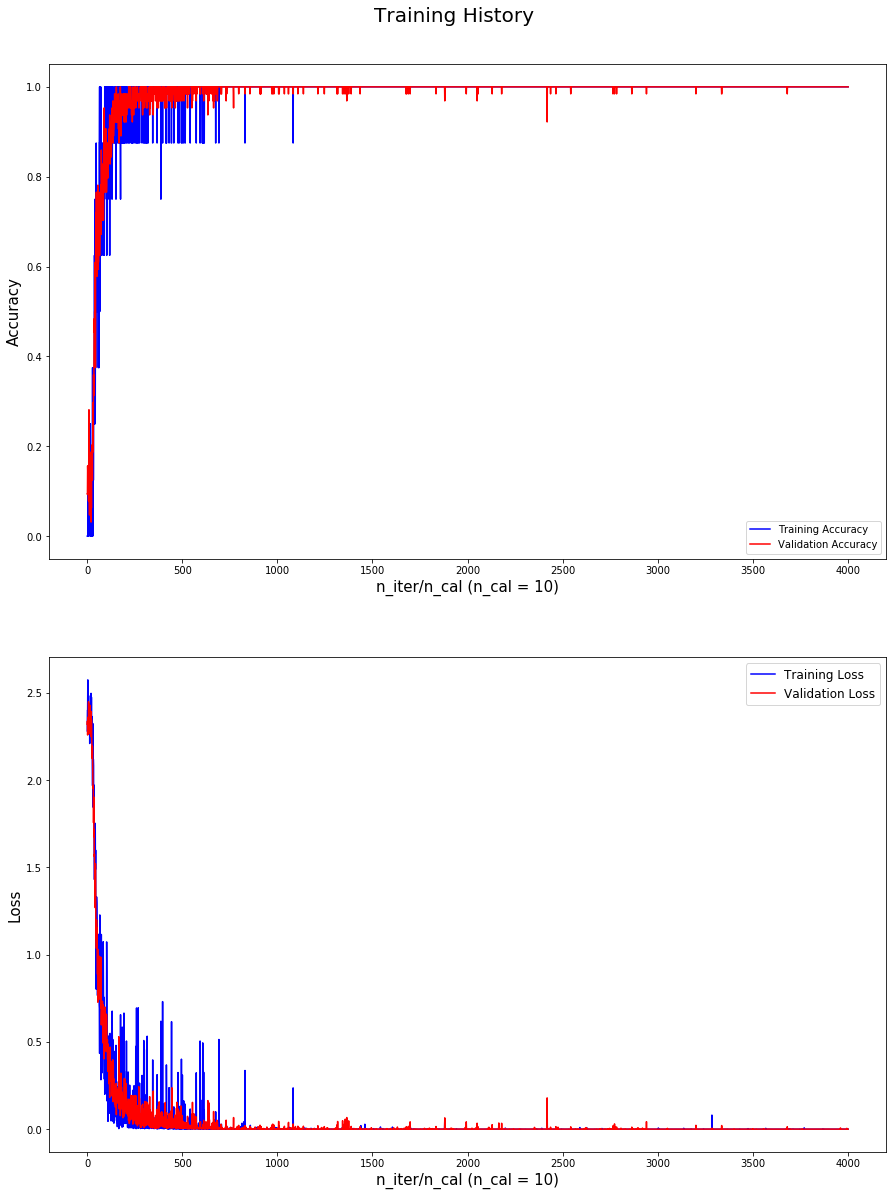

In [8]:
t_batch = 8
v_batch = 64
n_cal = 10
n_prt = 100

n_iter = 0

# LR = 1e-4 # 1e-4 ~ 5e-4 (xavier)
lr = 1e-4

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
# optm = tf.train.AdamOptimizer(lr).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
start_time = time.time() 

accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
early_stopping = False

hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

while True:
    train_x, train_y = random_minibatch(train_X, train_Y, batch_size = t_batch)
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :1})
    n_iter += 1
    if n_iter % n_cal == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'bn_prob:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        valid_x, valid_y = random_minibatch(valid_X, valid_Y, batch_size = v_batch)
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'bn_prob:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % n_prt == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'hht_6ch_res50_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/HHT/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 1000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          

train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50_HHT_6ch_accr', np.array(accr_train))
np.save('/mnt/disk1/yunseob/courses/19-2_computer vision/history/ResNet50_HHT_6ch_loss', np.array(loss_train))

hist.plot(n_cal)   

# sess.close()